In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.Sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            # layer = GENConv(channel_ls[i], channel_ls[i+1], aggr='powermean', learn_p=True, edge_dim=1)
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [6]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.8, gamma=0.8, dropout=0.3):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        # forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        # input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        new_A = F.tanh(F.relu(new_A))

        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [8]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [9]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [10]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.7, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls, alpha, epoch_weight):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)


    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * epoch_weight
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss


def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [11]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=64)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=36)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


21236456

In [12]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    beta = 1
    up_gamma = 1
    down_gamma = 1
    epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
            
        if (epoch + 1) % 10 == 0:
            epoch_weight = 1 / ((epoch + completed_epochs + 1) ** 0.2)


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            down_batch_loss = []
            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_batch_loss.append(down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1]))
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss = torch.mean(torch.stack(down_batch_loss))
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            del down_batch_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            up_batch_loss = []

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_batch_loss.append(up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.75, epoch_weight=epoch_weight))
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss = torch.mean(torch.stack(up_batch_loss))
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            del up_batch_loss
            torch.cuda.empty_cache()

        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'epoch {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [13]:
up_changer, down_changer, loss_log = train(400, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

100%|██████████| 3/3 [00:31<00:00, 10.61s/it]


epoch 0: down loss = 0.18420620262622833, up loss = 0.14053652683893839
Down end adj mae 0.21140073736508688
Up end adj mae 0.27667152881622314


100%|██████████| 3/3 [00:29<00:00,  9.86s/it]


epoch 1: down loss = 0.18122555812199911, up loss = 0.13264665752649307
Down end adj mae 0.21452183028062186
Up end adj mae 0.26757412155469257


100%|██████████| 3/3 [00:28<00:00,  9.44s/it]


epoch 2: down loss = 0.1691788136959076, up loss = 0.1353315363327662
Down end adj mae 0.20883543292681375
Up end adj mae 0.2751573820908864


100%|██████████| 3/3 [00:28<00:00,  9.40s/it]


epoch 3: down loss = 0.1587985704342524, up loss = 0.1389716366926829
Down end adj mae 0.20694859325885773
Up end adj mae 0.27872921029726666


100%|██████████| 3/3 [00:27<00:00,  9.15s/it]


epoch 4: down loss = 0.15569791694482168, up loss = 0.132355327407519
Down end adj mae 0.19979818165302277
Up end adj mae 0.26937601963679


100%|██████████| 3/3 [00:26<00:00,  8.93s/it]


epoch 5: down loss = 0.14583593606948853, up loss = 0.12887617448965707
Down end adj mae 0.20476289093494415
Up end adj mae 0.2673972447713216


100%|██████████| 3/3 [00:27<00:00,  9.15s/it]


epoch 6: down loss = 0.14725605646769205, up loss = 0.11997658262650172
Down end adj mae 0.20332634449005127
Up end adj mae 0.26350973049799603


100%|██████████| 3/3 [00:26<00:00,  8.71s/it]


epoch 7: down loss = 0.14105011026064554, up loss = 0.12000484019517899
Down end adj mae 0.21037993828455606
Up end adj mae 0.2659180959065755


100%|██████████| 3/3 [00:26<00:00,  8.91s/it]


epoch 8: down loss = 0.12993066509564719, up loss = 0.11994635562102
Down end adj mae 0.20454582075277963
Up end adj mae 0.26538196206092834


100%|██████████| 3/3 [00:26<00:00,  8.69s/it]


epoch 9: down loss = 0.13893002271652222, up loss = 0.11193405091762543
Down end adj mae 0.20713321367899576
Up end adj mae 0.26980852087338764


100%|██████████| 3/3 [00:26<00:00,  8.98s/it]


epoch 10: down loss = 0.1351731469233831, up loss = 0.10385763396819432
Down end adj mae 0.20257262885570526
Up end adj mae 0.2590915908416112


100%|██████████| 3/3 [00:26<00:00,  8.67s/it]


epoch 11: down loss = 0.13311410446961722, up loss = 0.10763136794169743
Down end adj mae 0.20100827515125275
Up end adj mae 0.25935189922650653


100%|██████████| 3/3 [00:26<00:00,  8.83s/it]


epoch 12: down loss = 0.12194819748401642, up loss = 0.10102605322996776
Down end adj mae 0.1988743096590042
Up end adj mae 0.252627561489741


100%|██████████| 3/3 [00:25<00:00,  8.52s/it]


epoch 13: down loss = 0.12095017234484355, up loss = 0.10076365619897842
Down end adj mae 0.20128585894902548
Up end adj mae 0.2525729437669118


100%|██████████| 3/3 [00:25<00:00,  8.57s/it]


epoch 14: down loss = 0.11202356219291687, up loss = 0.09872554242610931
Down end adj mae 0.20797146360079447
Up end adj mae 0.2546764512856801


100%|██████████| 3/3 [00:24<00:00,  8.29s/it]


epoch 15: down loss = 0.11027306069930394, up loss = 0.09425643334786098
Down end adj mae 0.2047520081202189
Up end adj mae 0.24981765945752463


100%|██████████| 3/3 [00:24<00:00,  8.27s/it]


epoch 16: down loss = 0.10621185352404912, up loss = 0.09679141889015834
Down end adj mae 0.20764805376529694
Up end adj mae 0.2564459641774495


100%|██████████| 3/3 [00:25<00:00,  8.49s/it]


epoch 17: down loss = 0.10234986493984859, up loss = 0.09292256583770116
Down end adj mae 0.2054941455523173
Up end adj mae 0.250791072845459


100%|██████████| 3/3 [00:24<00:00,  8.19s/it]


epoch 18: down loss = 0.10759058843056361, up loss = 0.09240115433931351
Down end adj mae 0.1963272988796234
Up end adj mae 0.24025205274422964


100%|██████████| 3/3 [00:24<00:00,  8.27s/it]


epoch 19: down loss = 0.1067788874109586, up loss = 0.09215503931045532
Down end adj mae 0.2125188410282135
Up end adj mae 0.2492827077706655


100%|██████████| 3/3 [00:25<00:00,  8.38s/it]


epoch 20: down loss = 0.09902608394622803, up loss = 0.09056838601827621
Down end adj mae 0.19887002309163412
Up end adj mae 0.2451645533243815


100%|██████████| 3/3 [00:24<00:00,  8.21s/it]


epoch 21: down loss = 0.09817004948854446, up loss = 0.08762503663698833
Down end adj mae 0.20010608434677124
Up end adj mae 0.24317434430122375


100%|██████████| 3/3 [00:24<00:00,  8.24s/it]


epoch 22: down loss = 0.1019492819905281, up loss = 0.08808552970488866
Down end adj mae 0.1949097365140915
Up end adj mae 0.2404493788878123


100%|██████████| 3/3 [00:24<00:00,  8.26s/it]


epoch 23: down loss = 0.09529063105583191, up loss = 0.08662038544813792
Down end adj mae 0.19251281023025513
Up end adj mae 0.2401716411113739


100%|██████████| 3/3 [00:24<00:00,  8.26s/it]


epoch 24: down loss = 0.09835983564456303, up loss = 0.08862215528885524
Down end adj mae 0.19819502035776773
Up end adj mae 0.24283123016357422


100%|██████████| 3/3 [00:25<00:00,  8.38s/it]


epoch 25: down loss = 0.08989449590444565, up loss = 0.08383491386969884
Down end adj mae 0.19148239493370056
Up end adj mae 0.2306366910537084


100%|██████████| 3/3 [00:24<00:00,  8.23s/it]


epoch 26: down loss = 0.08866892009973526, up loss = 0.0803053875764211
Down end adj mae 0.19727221628030142
Up end adj mae 0.23521933952967325


100%|██████████| 3/3 [00:24<00:00,  8.15s/it]


epoch 27: down loss = 0.09367502232392629, up loss = 0.0853129227956136
Down end adj mae 0.19178862373034158
Up end adj mae 0.23250800371170044


100%|██████████| 3/3 [00:24<00:00,  8.18s/it]


epoch 28: down loss = 0.09105316797892253, up loss = 0.08420795202255249
Down end adj mae 0.19818892081578574
Up end adj mae 0.24099153776963553


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 29: down loss = 0.09240171313285828, up loss = 0.08385352790355682
Down end adj mae 0.19480523963769278
Up end adj mae 0.238275075952212


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 30: down loss = 0.08415917307138443, up loss = 0.081761268277963
Down end adj mae 0.19610809783140817
Up end adj mae 0.2335105041662852


100%|██████████| 3/3 [00:24<00:00,  8.23s/it]


epoch 31: down loss = 0.08849527190128963, up loss = 0.07844697435696919
Down end adj mae 0.1821702172358831
Up end adj mae 0.22578541934490204


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 32: down loss = 0.08636070787906647, up loss = 0.07899205138285954
Down end adj mae 0.19112469255924225
Up end adj mae 0.2275053064028422


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 33: down loss = 0.08707914501428604, up loss = 0.07969265182813008
Down end adj mae 0.18374003469944
Up end adj mae 0.22947952648003897


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 34: down loss = 0.0815509706735611, up loss = 0.07786181569099426
Down end adj mae 0.18868053456147513
Up end adj mae 0.22534594933191934


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 35: down loss = 0.08896863212188084, up loss = 0.07773746798435847
Down end adj mae 0.1873738169670105
Up end adj mae 0.22371220091978708


100%|██████████| 3/3 [00:24<00:00,  8.13s/it]


epoch 36: down loss = 0.08178339650233586, up loss = 0.07404681543509166
Down end adj mae 0.1923720786968867
Up end adj mae 0.22264205912748972


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 37: down loss = 0.08865610510110855, up loss = 0.07622771213452022
Down end adj mae 0.18713551263014475
Up end adj mae 0.22191808124383292


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 38: down loss = 0.0783799762527148, up loss = 0.07420978198448817
Down end adj mae 0.18719608585039774
Up end adj mae 0.2220174769560496


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 39: down loss = 0.08529126395781834, up loss = 0.07363980015118916
Down end adj mae 0.18601197004318237
Up end adj mae 0.22043801844120026


100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


epoch 40: down loss = 0.08116985112428665, up loss = 0.06999753663937251
Down end adj mae 0.18013052145640054
Up end adj mae 0.21332177023092905


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 41: down loss = 0.07179016868273418, up loss = 0.06877672920624416
Down end adj mae 0.18206704159577689
Up end adj mae 0.21509777009487152


100%|██████████| 3/3 [00:22<00:00,  7.63s/it]


epoch 42: down loss = 0.07366504023472469, up loss = 0.06737041473388672
Down end adj mae 0.17950662970542908
Up end adj mae 0.2099953293800354


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 43: down loss = 0.07381317516167958, up loss = 0.07068486760059993
Down end adj mae 0.1856009711821874
Up end adj mae 0.21565274397532144


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 44: down loss = 0.07467711220184962, up loss = 0.06753079096476237
Down end adj mae 0.18275625507036844
Up end adj mae 0.2092314213514328


100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


epoch 45: down loss = 0.08105122298002243, up loss = 0.06581619133551915
Down end adj mae 0.17759020129839578
Up end adj mae 0.205116738875707


100%|██████████| 3/3 [00:22<00:00,  7.49s/it]


epoch 46: down loss = 0.07906686266263326, up loss = 0.06763790299495061
Down end adj mae 0.18102278808752695
Up end adj mae 0.21083096663157144


100%|██████████| 3/3 [00:23<00:00,  7.70s/it]


epoch 47: down loss = 0.07526031136512756, up loss = 0.06259449571371078
Down end adj mae 0.18180910249551138
Up end adj mae 0.20586864153544107


100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


epoch 48: down loss = 0.08245501170555751, up loss = 0.06650058676799138
Down end adj mae 0.17211495339870453
Up end adj mae 0.205301433801651


100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


epoch 49: down loss = 0.07695813477039337, up loss = 0.060882069170475006
Down end adj mae 0.17190816501776376
Up end adj mae 0.19451736410458884


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 50: down loss = 0.0696385105450948, up loss = 0.06088400880495707
Down end adj mae 0.1731453835964203
Up end adj mae 0.2004066308339437


100%|██████████| 3/3 [00:23<00:00,  7.70s/it]


epoch 51: down loss = 0.07253818213939667, up loss = 0.05917790656288465
Down end adj mae 0.1720433235168457
Up end adj mae 0.19348972539107004


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 52: down loss = 0.07185377180576324, up loss = 0.05885735029975573
Down end adj mae 0.16980279485384622
Up end adj mae 0.19335836172103882


100%|██████████| 3/3 [00:23<00:00,  7.67s/it]


epoch 53: down loss = 0.07361781100432079, up loss = 0.06014476219813029
Down end adj mae 0.1690730502208074
Up end adj mae 0.19380194942156473


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 54: down loss = 0.07324753453334172, up loss = 0.05672178169091543
Down end adj mae 0.1689782440662384
Up end adj mae 0.1898143341143926


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 55: down loss = 0.0769079253077507, up loss = 0.05822312831878662
Down end adj mae 0.16492989162604013
Up end adj mae 0.1908484548330307


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 56: down loss = 0.06488000229001045, up loss = 0.054151648034652076
Down end adj mae 0.16337662935256958
Up end adj mae 0.18357989192008972


100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


epoch 57: down loss = 0.06598453347881635, up loss = 0.05511812741557757
Down end adj mae 0.16611946125825247
Up end adj mae 0.19100948174794516


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 58: down loss = 0.0636477197209994, up loss = 0.052261405934890114
Down end adj mae 0.1666070967912674
Up end adj mae 0.1820775270462036


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 59: down loss = 0.0725990782181422, up loss = 0.05372939879695574
Down end adj mae 0.16559883455435434
Up end adj mae 0.18201818565527597


100%|██████████| 3/3 [00:22<00:00,  7.64s/it]


epoch 60: down loss = 0.06619611009955406, up loss = 0.05249327917893728
Down end adj mae 0.16342334945996603
Up end adj mae 0.1810097595055898


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 61: down loss = 0.06628993277748425, up loss = 0.04960450530052185
Down end adj mae 0.16696062684059143
Up end adj mae 0.17972823480765024


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 62: down loss = 0.06526131803790729, up loss = 0.05201060945789019
Down end adj mae 0.16070427000522614
Up end adj mae 0.17601684232552847


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 63: down loss = 0.075867909938097, up loss = 0.052328220258156456
Down end adj mae 0.16190719107786813
Up end adj mae 0.1774926781654358


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 64: down loss = 0.06395212436715762, up loss = 0.04645933707555135
Down end adj mae 0.1618659645318985
Up end adj mae 0.16889757414658865


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 65: down loss = 0.06477316096425056, up loss = 0.048884631445010505
Down end adj mae 0.15703902145226797
Up end adj mae 0.17182332277297974


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 66: down loss = 0.06552319104472797, up loss = 0.04913042734066645
Down end adj mae 0.16198751827081045
Up end adj mae 0.17869226137797037


100%|██████████| 3/3 [00:24<00:00,  8.18s/it]


epoch 67: down loss = 0.06019254277149836, up loss = 0.0440883015592893
Down end adj mae 0.15867404143015543
Up end adj mae 0.16476213932037354


100%|██████████| 3/3 [00:23<00:00,  7.67s/it]


epoch 68: down loss = 0.06165534754594167, up loss = 0.044902184357245765
Down end adj mae 0.1659775177637736
Up end adj mae 0.1680582861105601


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 69: down loss = 0.05996239433685938, up loss = 0.04345718398690224
Down end adj mae 0.16364656885464987
Up end adj mae 0.17235839863618216


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 70: down loss = 0.06579083700974782, up loss = 0.04518421863516172
Down end adj mae 0.1664165804783503
Up end adj mae 0.1716880202293396


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 71: down loss = 0.059870256731907524, up loss = 0.04345018664995829
Down end adj mae 0.16525386273860931
Up end adj mae 0.17113281786441803


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 72: down loss = 0.05430029705166817, up loss = 0.04189566895365715
Down end adj mae 0.16341590881347656
Up end adj mae 0.16637887557347616


100%|██████████| 3/3 [00:23<00:00,  7.68s/it]


epoch 73: down loss = 0.05793702229857445, up loss = 0.04162268837292989
Down end adj mae 0.15764198203881583
Up end adj mae 0.16152862211068472


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 74: down loss = 0.060974267621835075, up loss = 0.040829637398322426
Down end adj mae 0.16051961978276572
Up end adj mae 0.16119112571080527


100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


epoch 75: down loss = 0.0652008888622125, up loss = 0.04329795762896538
Down end adj mae 0.1657414585351944
Up end adj mae 0.1660275161266327


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 76: down loss = 0.05459825942913691, up loss = 0.03886887306968371
Down end adj mae 0.1621959904829661
Up end adj mae 0.16261825958887735


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 77: down loss = 0.05553728217879931, up loss = 0.03849610189596812
Down end adj mae 0.16319171587626138
Up end adj mae 0.16441723704338074


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 78: down loss = 0.054224162052075066, up loss = 0.038240195562442146
Down end adj mae 0.16070053478082022
Up end adj mae 0.16172673304875693


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 79: down loss = 0.06002506737907728, up loss = 0.0415591336786747
Down end adj mae 0.15933528045813242
Up end adj mae 0.16360590358575186


100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


epoch 80: down loss = 0.05267607420682907, up loss = 0.03799897059798241
Down end adj mae 0.1594601273536682
Up end adj mae 0.15975430607795715


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 81: down loss = 0.06120377530654272, up loss = 0.03992483268181483
Down end adj mae 0.16406373182932535
Up end adj mae 0.1652002235253652


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 82: down loss = 0.055600294222434364, up loss = 0.037280416737000145
Down end adj mae 0.15573621292908987
Up end adj mae 0.1562939981619517


100%|██████████| 3/3 [00:24<00:00,  8.25s/it]


epoch 83: down loss = 0.05394941692550977, up loss = 0.036605543146530785
Down end adj mae 0.15969120959440866
Up end adj mae 0.15825906892617544


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 84: down loss = 0.05249844118952751, up loss = 0.03658719112475713
Down end adj mae 0.16018694639205933
Up end adj mae 0.15989134709040323


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 85: down loss = 0.05730322251717249, up loss = 0.03925508509079615
Down end adj mae 0.15587319930394491
Up end adj mae 0.15890351931254068


100%|██████████| 3/3 [00:23<00:00,  8.00s/it]


epoch 86: down loss = 0.055013835430145264, up loss = 0.036933429539203644
Down end adj mae 0.15827778975168863
Up end adj mae 0.15773741404215494


100%|██████████| 3/3 [00:24<00:00,  8.22s/it]


epoch 87: down loss = 0.05303333327174187, up loss = 0.03602281336983045
Down end adj mae 0.15816534062226614
Up end adj mae 0.15713760256767273


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 88: down loss = 0.05793521801630656, up loss = 0.03884843488534292
Down end adj mae 0.1605412314335505
Up end adj mae 0.16096257170041403


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 89: down loss = 0.054739835361639656, up loss = 0.03774726763367653
Down end adj mae 0.16365186870098114
Up end adj mae 0.166432852546374


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 90: down loss = 0.053685822834571205, up loss = 0.03647962212562561
Down end adj mae 0.15681796769301096
Up end adj mae 0.15856881936391196


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 91: down loss = 0.052187006920576096, up loss = 0.03594238435228666
Down end adj mae 0.15709879994392395
Up end adj mae 0.15694346030553183


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 92: down loss = 0.059649708370367684, up loss = 0.03792023782928785
Down end adj mae 0.1610406438509623
Up end adj mae 0.15977920095125833


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 93: down loss = 0.050738257666428886, up loss = 0.03618405262629191
Down end adj mae 0.15824460486570993
Up end adj mae 0.1593029499053955


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 94: down loss = 0.05163143575191498, up loss = 0.035578868041435875
Down end adj mae 0.1616430381933848
Up end adj mae 0.15861462553342184


100%|██████████| 3/3 [00:24<00:00,  8.07s/it]


epoch 95: down loss = 0.050590320179859795, up loss = 0.034944100926319756
Down end adj mae 0.1541322668393453
Up end adj mae 0.15483524401982626


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 96: down loss = 0.04966078201929728, up loss = 0.0348259632786115
Down end adj mae 0.15465331574281058
Up end adj mae 0.1561089406410853


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 97: down loss = 0.05557930345336596, up loss = 0.037467376639445625
Down end adj mae 0.15858813126881918
Up end adj mae 0.16175214449564615


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 98: down loss = 0.05094099541505178, up loss = 0.03541109710931778
Down end adj mae 0.15739618241786957
Up end adj mae 0.15860280891259512


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 99: down loss = 0.047747994462649025, up loss = 0.03398233403762182
Down end adj mae 0.15903204182783762
Up end adj mae 0.1578213224808375


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 100: down loss = 0.05719649170835813, up loss = 0.03729217623670896
Down end adj mae 0.15618197123209634
Up end adj mae 0.15837364395459494


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 101: down loss = 0.045892311880985893, up loss = 0.03405012935400009
Down end adj mae 0.15499451756477356
Up end adj mae 0.15460573136806488


100%|██████████| 3/3 [00:24<00:00,  8.14s/it]


epoch 102: down loss = 0.05717605724930763, up loss = 0.035004968444506325
Down end adj mae 0.1557990461587906
Up end adj mae 0.15770705540974936


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 103: down loss = 0.049490656703710556, up loss = 0.03583082060019175
Down end adj mae 0.1588991234699885
Up end adj mae 0.16061411798000336


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 104: down loss = 0.04719784234960874, up loss = 0.03464210902651151
Down end adj mae 0.15804044902324677
Up end adj mae 0.15892091393470764


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 105: down loss = 0.05084320902824402, up loss = 0.03468070179224014
Down end adj mae 0.16054109235604605
Up end adj mae 0.1577699581782023


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 106: down loss = 0.04804600651065508, up loss = 0.03413603579004606
Down end adj mae 0.1577774037917455
Up end adj mae 0.1578961710135142


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 107: down loss = 0.04732553536693255, up loss = 0.0342815654973189
Down end adj mae 0.15753580133120218
Up end adj mae 0.1559781680504481


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 108: down loss = 0.046367861330509186, up loss = 0.03314149131377538
Down end adj mae 0.15465781092643738
Up end adj mae 0.15331206222375235


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 109: down loss = 0.04479449118177096, up loss = 0.03296754385034243
Down end adj mae 0.1543974628051122
Up end adj mae 0.15508450071016947


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 110: down loss = 0.04444331551591555, up loss = 0.03310827165842056
Down end adj mae 0.15688244998455048
Up end adj mae 0.15693077445030212


100%|██████████| 3/3 [00:23<00:00,  8.00s/it]


epoch 111: down loss = 0.0451459102332592, up loss = 0.033690509696801506
Down end adj mae 0.1581172396739324
Up end adj mae 0.15765695770581564


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 112: down loss = 0.044855779657761254, up loss = 0.0326596995194753
Down end adj mae 0.15519247452418009
Up end adj mae 0.1550649106502533


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 113: down loss = 0.05417268102367719, up loss = 0.036699106295903526
Down end adj mae 0.15560891727606455
Up end adj mae 0.15691239138444266


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 114: down loss = 0.05024621387322744, up loss = 0.034289432068665825
Down end adj mae 0.15928052365779877
Up end adj mae 0.15783633291721344


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 115: down loss = 0.04854133973519007, up loss = 0.03487218668063482
Down end adj mae 0.16076320906480154
Up end adj mae 0.1591634452342987


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 116: down loss = 0.04890136793255806, up loss = 0.034688837826251984
Down end adj mae 0.1579841027657191
Up end adj mae 0.1585992028315862


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 117: down loss = 0.05043740446368853, up loss = 0.033701284478108086
Down end adj mae 0.15535936752955118
Up end adj mae 0.15288988252480826


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 118: down loss = 0.05028885727127393, up loss = 0.03606952726840973
Down end adj mae 0.15358259777228037
Up end adj mae 0.1593810866276423


100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


epoch 119: down loss = 0.049104144175847374, up loss = 0.03431914498408636
Down end adj mae 0.15452727178732553
Up end adj mae 0.154913862546285


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 120: down loss = 0.04733633125821749, up loss = 0.03317345306277275
Down end adj mae 0.1507485955953598
Up end adj mae 0.14984622100989023


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 121: down loss = 0.051933497190475464, up loss = 0.03459867710868517
Down end adj mae 0.15464183688163757
Up end adj mae 0.1552477478981018


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 122: down loss = 0.05111899723609289, up loss = 0.03448787207404772
Down end adj mae 0.15680884818236032
Up end adj mae 0.1564008891582489


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 123: down loss = 0.04959147423505783, up loss = 0.03346976886192957
Down end adj mae 0.15313340723514557
Up end adj mae 0.15320613980293274


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 124: down loss = 0.05369482437769572, up loss = 0.03484832619627317
Down end adj mae 0.15608697136243185
Up end adj mae 0.16061160961786905


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 125: down loss = 0.050205896298090615, up loss = 0.033838449666897454
Down end adj mae 0.15454975763956705
Up end adj mae 0.15364857017993927


100%|██████████| 3/3 [00:24<00:00,  8.12s/it]


epoch 126: down loss = 0.04433902849753698, up loss = 0.032390816137194633
Down end adj mae 0.15491593380769095
Up end adj mae 0.15422614415486655


100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


epoch 127: down loss = 0.052732910960912704, up loss = 0.03408521662155787
Down end adj mae 0.15740189452966055
Up end adj mae 0.15354030827681223


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 128: down loss = 0.05485584711035093, up loss = 0.03295773888627688
Down end adj mae 0.15477404495080313
Up end adj mae 0.1554141789674759


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


epoch 129: down loss = 0.044238207240899406, up loss = 0.03223813325166702
Down end adj mae 0.1516428291797638
Up end adj mae 0.15291235347588858


100%|██████████| 3/3 [00:24<00:00,  8.14s/it]


epoch 130: down loss = 0.046043659249941506, up loss = 0.03265258048971494
Down end adj mae 0.1535490701595942
Up end adj mae 0.1553867111603419


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 131: down loss = 0.04145706196626028, up loss = 0.031654986242453255
Down end adj mae 0.1527783473332723
Up end adj mae 0.154801274339358


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 132: down loss = 0.050350296000639595, up loss = 0.0325927808880806
Down end adj mae 0.15607755879561105
Up end adj mae 0.15585931142171225


100%|██████████| 3/3 [00:24<00:00,  8.22s/it]


epoch 133: down loss = 0.04299232239524523, up loss = 0.032268824676672615
Down end adj mae 0.15419206519921622
Up end adj mae 0.1547607978185018


100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


epoch 134: down loss = 0.04281940311193466, up loss = 0.031693133835991226
Down end adj mae 0.1499049166838328
Up end adj mae 0.15115136901537576


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 135: down loss = 0.04445775101582209, up loss = 0.03140905499458313
Down end adj mae 0.15272852778434753
Up end adj mae 0.15213876962661743


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 136: down loss = 0.042835171024004616, up loss = 0.033035931487878166
Down end adj mae 0.15170429646968842
Up end adj mae 0.1519831418991089


100%|██████████| 3/3 [00:24<00:00,  8.13s/it]


epoch 137: down loss = 0.0423018808166186, up loss = 0.03167630359530449
Down end adj mae 0.15014749765396118
Up end adj mae 0.15118995805581412


100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


epoch 138: down loss = 0.050082556903362274, up loss = 0.03452066890895367
Down end adj mae 0.15230550865332285
Up end adj mae 0.15417131781578064


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 139: down loss = 0.05248795201381048, up loss = 0.03448984275261561
Down end adj mae 0.15441890557607016
Up end adj mae 0.1583663523197174


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 140: down loss = 0.051005846510330834, up loss = 0.03539556264877319
Down end adj mae 0.15295683840910593
Up end adj mae 0.15596315761407217


100%|██████████| 3/3 [00:24<00:00,  8.16s/it]


epoch 141: down loss = 0.042078275233507156, up loss = 0.03163690368334452
Down end adj mae 0.15230312943458557
Up end adj mae 0.1523816188176473


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 142: down loss = 0.040334898978471756, up loss = 0.031073795010646183
Down end adj mae 0.1527445117632548
Up end adj mae 0.15477478007475534


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 143: down loss = 0.04538998877008756, up loss = 0.03313929649690787
Down end adj mae 0.15199774503707886
Up end adj mae 0.15632106363773346


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


epoch 144: down loss = 0.04542814070979754, up loss = 0.03269539028406143
Down end adj mae 0.151228000720342
Up end adj mae 0.15555656949679056


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 145: down loss = 0.04055884728829066, up loss = 0.030823855971296627
Down end adj mae 0.15313372512658438
Up end adj mae 0.15498943130175272


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 146: down loss = 0.047496408224105835, up loss = 0.03311345850427946
Down end adj mae 0.15450908243656158
Up end adj mae 0.1559791018565496


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 147: down loss = 0.04637930914759636, up loss = 0.03237949808438619
Down end adj mae 0.15269858638445535
Up end adj mae 0.15490804612636566


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 148: down loss = 0.04568536455432574, up loss = 0.030909983441233635
Down end adj mae 0.1520742873350779
Up end adj mae 0.1535304089387258


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 149: down loss = 0.04049110412597656, up loss = 0.031745790193478264
Down end adj mae 0.14984934031963348
Up end adj mae 0.15239759782950082


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 150: down loss = 0.04239709178606669, up loss = 0.03120206979413827
Down end adj mae 0.1530209481716156
Up end adj mae 0.15453322231769562


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 151: down loss = 0.04610166326165199, up loss = 0.03317532129585743
Down end adj mae 0.15271633366743723
Up end adj mae 0.15305529534816742


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 152: down loss = 0.03970300157864889, up loss = 0.031213602051138878
Down end adj mae 0.15388005475203195
Up end adj mae 0.1551696608463923


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 153: down loss = 0.03986127550403277, up loss = 0.030591685324907303
Down end adj mae 0.15271349747975668
Up end adj mae 0.15317431588967642


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 154: down loss = 0.03989612932006518, up loss = 0.03012701744834582
Down end adj mae 0.15190769731998444
Up end adj mae 0.15216500560442606


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 155: down loss = 0.040544881174961724, up loss = 0.030277234812577564
Down end adj mae 0.15469610691070557
Up end adj mae 0.1547666589419047


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 156: down loss = 0.04341840619842211, up loss = 0.030974537134170532
Down end adj mae 0.1514619986216227
Up end adj mae 0.15349805851777396


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 157: down loss = 0.0385890764494737, up loss = 0.029983074714740116
Down end adj mae 0.15059486528237662
Up end adj mae 0.15041459600130716


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 158: down loss = 0.03966898222764333, up loss = 0.03115065147479375
Down end adj mae 0.15126522878805795
Up end adj mae 0.15402730802694956


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 159: down loss = 0.04369825248916944, up loss = 0.03134419955313206
Down end adj mae 0.154054989417394
Up end adj mae 0.15448759496212006


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 160: down loss = 0.03807752082745234, up loss = 0.02992025452355544
Down end adj mae 0.15044425427913666
Up end adj mae 0.152694304784139


100%|██████████| 3/3 [00:24<00:00,  8.11s/it]


epoch 161: down loss = 0.058159382392962776, up loss = 0.034734719122449555
Down end adj mae 0.15076265235741934
Up end adj mae 0.15143926938374838


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 162: down loss = 0.047326033314069114, up loss = 0.031753964722156525
Down end adj mae 0.15337116519610086
Up end adj mae 0.15320763985315958


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


epoch 163: down loss = 0.043923329561948776, up loss = 0.030985324333111446
Down end adj mae 0.1525632937749227
Up end adj mae 0.15397830804189047


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 164: down loss = 0.04281394680341085, up loss = 0.0311106126755476
Down end adj mae 0.14904905358950296
Up end adj mae 0.15040144324302673


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 165: down loss = 0.037875170509020485, up loss = 0.029615469897786777
Down end adj mae 0.1526472568511963
Up end adj mae 0.15309345722198486


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


epoch 166: down loss = 0.04130761822064718, up loss = 0.030803173780441284
Down end adj mae 0.1514144092798233
Up end adj mae 0.15293056269486746


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 167: down loss = 0.046942116071780525, up loss = 0.032036647821466126
Down end adj mae 0.152279923359553
Up end adj mae 0.15552197893460593


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 168: down loss = 0.038662941505511604, up loss = 0.030634282156825066
Down end adj mae 0.1511295090119044
Up end adj mae 0.15500578780968985


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 169: down loss = 0.038412133852640785, up loss = 0.030738358696301777
Down end adj mae 0.14994814495245615
Up end adj mae 0.15224459767341614


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 170: down loss = 0.03784620016813278, up loss = 0.029550252482295036
Down end adj mae 0.14980745812257132
Up end adj mae 0.1490248292684555


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 171: down loss = 0.038586278756459556, up loss = 0.029609890033801396
Down end adj mae 0.1525098830461502
Up end adj mae 0.15202509860197702


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 172: down loss = 0.036867085844278336, up loss = 0.02998284250497818
Down end adj mae 0.149007981022199
Up end adj mae 0.1516958624124527


100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


epoch 173: down loss = 0.047476651767889656, up loss = 0.030847078810135525
Down end adj mae 0.1502015938361486
Up end adj mae 0.15139053761959076


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 174: down loss = 0.036537881940603256, up loss = 0.02934605876604716
Down end adj mae 0.14908532798290253
Up end adj mae 0.15056831141312918


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 175: down loss = 0.037215373168389, up loss = 0.0291966013610363
Down end adj mae 0.15017110109329224
Up end adj mae 0.15222863852977753


100%|██████████| 3/3 [00:24<00:00,  8.07s/it]


epoch 176: down loss = 0.04614793385068575, up loss = 0.03271123766899109
Down end adj mae 0.15007942914962769
Up end adj mae 0.1549466997385025


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 177: down loss = 0.042340394109487534, up loss = 0.031099678327639897
Down end adj mae 0.14910727739334106
Up end adj mae 0.15214695036411285


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 178: down loss = 0.04553402836124102, up loss = 0.032682919253905617
Down end adj mae 0.15216533839702606
Up end adj mae 0.15429430703322092


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 179: down loss = 0.03857391079266866, up loss = 0.029612105960647266
Down end adj mae 0.1495469262202581
Up end adj mae 0.14948445558547974


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 180: down loss = 0.04048031692703565, up loss = 0.029460095490018528
Down end adj mae 0.1478810558716456
Up end adj mae 0.14912225802739462


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 181: down loss = 0.038817841559648514, up loss = 0.030004099011421204
Down end adj mae 0.15070785085360208
Up end adj mae 0.15185774862766266


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 182: down loss = 0.043553332487742104, up loss = 0.030629649758338928
Down end adj mae 0.15108885864416757
Up end adj mae 0.15332005421320596


100%|██████████| 3/3 [00:24<00:00,  8.22s/it]


epoch 183: down loss = 0.037238424022992454, up loss = 0.02983345091342926
Down end adj mae 0.14841634035110474
Up end adj mae 0.14981198807557425


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 184: down loss = 0.03967107832431793, up loss = 0.029645707458257675
Down end adj mae 0.14817738036314645
Up end adj mae 0.1490889936685562


100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


epoch 185: down loss = 0.03719785064458847, up loss = 0.029204380388061207
Down end adj mae 0.1526432087024053
Up end adj mae 0.15250402192274728


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 186: down loss = 0.039076823741197586, up loss = 0.03020850569009781
Down end adj mae 0.1483213702837626
Up end adj mae 0.15088378389676413


100%|██████████| 3/3 [00:24<00:00,  8.18s/it]


epoch 187: down loss = 0.04193267350395521, up loss = 0.03193017219503721
Down end adj mae 0.14894509315490723
Up end adj mae 0.15074812372525534


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 188: down loss = 0.03881550207734108, up loss = 0.029851287603378296
Down end adj mae 0.1492128223180771
Up end adj mae 0.15169186890125275


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 189: down loss = 0.051409389823675156, up loss = 0.03314173469940821
Down end adj mae 0.14976454774538675
Up end adj mae 0.15212871630986533


100%|██████████| 3/3 [00:24<00:00,  8.14s/it]


epoch 190: down loss = 0.04626841098070145, up loss = 0.03319966793060303
Down end adj mae 0.15047586957613626
Up end adj mae 0.15201221903165182


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 191: down loss = 0.03569664185245832, up loss = 0.02931657371421655
Down end adj mae 0.15153243641058603
Up end adj mae 0.15269137918949127


100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


epoch 192: down loss = 0.03865879153211912, up loss = 0.03011396713554859
Down end adj mae 0.1471241960922877
Up end adj mae 0.14865169922510782


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 193: down loss = 0.04125127320488294, up loss = 0.030795399099588394
Down end adj mae 0.15095922847588858
Up end adj mae 0.1540402521689733


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 194: down loss = 0.03703437993923823, up loss = 0.029518165936072666
Down end adj mae 0.1475751648346583
Up end adj mae 0.149509867032369


100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


epoch 195: down loss = 0.042063940316438675, up loss = 0.03018334445854028
Down end adj mae 0.14995741347471872
Up end adj mae 0.15213972330093384


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 196: down loss = 0.03673704216877619, up loss = 0.028789521505435307
Down end adj mae 0.14827466011047363
Up end adj mae 0.14816820621490479


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 197: down loss = 0.04289062445362409, up loss = 0.029798800125718117
Down end adj mae 0.14844515919685364
Up end adj mae 0.15175071358680725


100%|██████████| 3/3 [00:24<00:00,  8.11s/it]


epoch 198: down loss = 0.04291610916455587, up loss = 0.03176511637866497
Down end adj mae 0.14691257973512015
Up end adj mae 0.1520159294207891


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 199: down loss = 0.04171920443574587, up loss = 0.02980591480930646
Down end adj mae 0.14911421636740366
Up end adj mae 0.15043158332506815


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 200: down loss = 0.03686294828852018, up loss = 0.029615354413787525
Down end adj mae 0.1501205861568451
Up end adj mae 0.1514666626850764


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 201: down loss = 0.034898137052853904, up loss = 0.028803872565428417
Down end adj mae 0.14864679177602133
Up end adj mae 0.14880597591400146


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 202: down loss = 0.041498654832442604, up loss = 0.03099673055112362
Down end adj mae 0.14873352646827698
Up end adj mae 0.1520269215106964


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 203: down loss = 0.043180140356222786, up loss = 0.030566214273373287
Down end adj mae 0.1492079645395279
Up end adj mae 0.15304158627986908


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 204: down loss = 0.035639834900697075, up loss = 0.028756769994894665
Down end adj mae 0.14791888495286307
Up end adj mae 0.15009286999702454


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 205: down loss = 0.03979992866516113, up loss = 0.029908219973246258
Down end adj mae 0.1499357372522354
Up end adj mae 0.15231753389040628


100%|██████████| 3/3 [00:24<00:00,  8.19s/it]


epoch 206: down loss = 0.0368560254573822, up loss = 0.02839933956662814
Down end adj mae 0.14820774892965952
Up end adj mae 0.14817224442958832


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 207: down loss = 0.03783548126618067, up loss = 0.028325687473018963
Down end adj mae 0.1467286596695582
Up end adj mae 0.14922342201073965


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 208: down loss = 0.037752230962117515, up loss = 0.029954026142756145
Down end adj mae 0.15189908941586813
Up end adj mae 0.1565831998984019


100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


epoch 209: down loss = 0.03514662633339564, up loss = 0.028673814609646797
Down end adj mae 0.14813631772994995
Up end adj mae 0.1501005987326304


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 210: down loss = 0.043063500275214515, up loss = 0.03118349363406499
Down end adj mae 0.14848103125890097
Up end adj mae 0.15321417649586996


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 211: down loss = 0.039285132040580116, up loss = 0.030089535440007847
Down end adj mae 0.14973370730876923
Up end adj mae 0.15150726834932962


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


epoch 212: down loss = 0.046205310771862663, up loss = 0.03078370913863182
Down end adj mae 0.14540340999762216
Up end adj mae 0.1497013419866562


100%|██████████| 3/3 [00:24<00:00,  8.02s/it]


epoch 213: down loss = 0.03870512669285139, up loss = 0.028760214646657307
Down end adj mae 0.151791512966156
Up end adj mae 0.1539053072532018


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 214: down loss = 0.03684684510032336, up loss = 0.028641071170568466
Down end adj mae 0.14660904804865518
Up end adj mae 0.1490036497513453


100%|██████████| 3/3 [00:23<00:00,  7.67s/it]


epoch 215: down loss = 0.03870942567785581, up loss = 0.029135261351863544
Down end adj mae 0.14643182357152304
Up end adj mae 0.1498598506053289


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 216: down loss = 0.037152763456106186, up loss = 0.028514888137578964
Down end adj mae 0.15013710657755533
Up end adj mae 0.15063430865605673


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 217: down loss = 0.035763099789619446, up loss = 0.028565483788649242
Down end adj mae 0.1479029655456543
Up end adj mae 0.14931750297546387


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 218: down loss = 0.039790415515502296, up loss = 0.029385723794500034
Down end adj mae 0.14893830319245657
Up end adj mae 0.15074589848518372


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 219: down loss = 0.038222506642341614, up loss = 0.028445595875382423
Down end adj mae 0.14931649963061014
Up end adj mae 0.14845829705397287


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 220: down loss = 0.03421660636862119, up loss = 0.028175165876746178
Down end adj mae 0.15080479780832926
Up end adj mae 0.1511473556359609


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 221: down loss = 0.03407222032546997, up loss = 0.028807293623685837
Down end adj mae 0.14976531763871512
Up end adj mae 0.15152638157208762


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 222: down loss = 0.0450720377266407, up loss = 0.02947778006394704
Down end adj mae 0.14634577433268228
Up end adj mae 0.14942566553751627


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 223: down loss = 0.03633428613344828, up loss = 0.028304678077499073
Down end adj mae 0.1492088884115219
Up end adj mae 0.1504738728205363


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 224: down loss = 0.03594112768769264, up loss = 0.028167586773633957
Down end adj mae 0.15015321473280588
Up end adj mae 0.1512126326560974


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 225: down loss = 0.04523947462439537, up loss = 0.030230750019351642
Down end adj mae 0.15119241178035736
Up end adj mae 0.15414554377396902


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 226: down loss = 0.035135491440693535, up loss = 0.028211464484532673
Down end adj mae 0.14867501457532248
Up end adj mae 0.14946270982424417


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 227: down loss = 0.03770851343870163, up loss = 0.028370317071676254
Down end adj mae 0.15172680715719858
Up end adj mae 0.15315085152784982


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 228: down loss = 0.03401854758461317, up loss = 0.028669578954577446
Down end adj mae 0.14832021792729697
Up end adj mae 0.15110446015993753


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 229: down loss = 0.04280843834082285, up loss = 0.028902178009351093
Down end adj mae 0.15228423476219177
Up end adj mae 0.15284735461076102


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 230: down loss = 0.03644557669758797, up loss = 0.029208116854230564
Down end adj mae 0.14806947112083435
Up end adj mae 0.15120516220728555


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 231: down loss = 0.033394185826182365, up loss = 0.028153568506240845
Down end adj mae 0.14944037795066833
Up end adj mae 0.15119716028372446


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 232: down loss = 0.05636115372180939, up loss = 0.031194103881716728
Down end adj mae 0.1490981380144755
Up end adj mae 0.15307161708672842


100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


epoch 233: down loss = 0.03670932104190191, up loss = 0.028616534546017647
Down end adj mae 0.15020900964736938
Up end adj mae 0.15072329342365265


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 234: down loss = 0.03656347716848055, up loss = 0.029196615020434063
Down end adj mae 0.1474889268477758
Up end adj mae 0.1509662320216497


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 235: down loss = 0.041092379639546074, up loss = 0.029869824027021725
Down end adj mae 0.1519987334807714
Up end adj mae 0.1526902218659719


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 236: down loss = 0.03245645264784495, up loss = 0.02784694420794646
Down end adj mae 0.1473400890827179
Up end adj mae 0.14882569015026093


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 237: down loss = 0.0401035671432813, up loss = 0.02955806131164233
Down end adj mae 0.14910009503364563
Up end adj mae 0.15066599349180856


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 238: down loss = 0.03433644026517868, up loss = 0.027748065690199535
Down end adj mae 0.14802701771259308
Up end adj mae 0.14833254118760428


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 239: down loss = 0.03660729651649793, up loss = 0.029029475525021553
Down end adj mae 0.14979471266269684
Up end adj mae 0.15231571594874063


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 240: down loss = 0.035454715291659035, up loss = 0.028806880737344425
Down end adj mae 0.14892414708932242
Up end adj mae 0.15082495411237082


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 241: down loss = 0.03373801335692406, up loss = 0.0274207703769207
Down end adj mae 0.14554971953233084
Up end adj mae 0.14734450976053873


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 242: down loss = 0.03612056374549866, up loss = 0.028106775134801865
Down end adj mae 0.14687001705169678
Up end adj mae 0.14756573736667633


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 243: down loss = 0.035318574557701744, up loss = 0.028374943261345226
Down end adj mae 0.14988666772842407
Up end adj mae 0.1520888408025106


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 244: down loss = 0.03728947788476944, up loss = 0.027911951144536335
Down end adj mae 0.14847379426161447
Up end adj mae 0.15187176068623862


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 245: down loss = 0.036148653676112495, up loss = 0.02852168120443821
Down end adj mae 0.14502209424972534
Up end adj mae 0.1496185561021169


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 246: down loss = 0.034331691140929856, up loss = 0.028361239780982334
Down end adj mae 0.1477152407169342
Up end adj mae 0.15146537125110626


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 247: down loss = 0.03803625827034315, up loss = 0.028007708489894867
Down end adj mae 0.14812699457009634
Up end adj mae 0.14987560113271078


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 248: down loss = 0.03597681472698847, up loss = 0.028014061972498894
Down end adj mae 0.14587424198786417
Up end adj mae 0.1473031590382258


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 249: down loss = 0.03483890121181806, up loss = 0.028618747368454933
Down end adj mae 0.14881542325019836
Up end adj mae 0.15344818929831186


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 250: down loss = 0.03922403231263161, up loss = 0.0287362989038229
Down end adj mae 0.14684940377871195
Up end adj mae 0.14926056067148843


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 251: down loss = 0.0481433259944121, up loss = 0.03139966477950414
Down end adj mae 0.1469543476899465
Up end adj mae 0.1546883980433146


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 252: down loss = 0.04603408401211103, up loss = 0.030254042396942776
Down end adj mae 0.14840484162171683
Up end adj mae 0.14983095725377402


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 253: down loss = 0.04334071030219396, up loss = 0.029035041108727455
Down end adj mae 0.15020165344079336
Up end adj mae 0.15016685922940573


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 254: down loss = 0.03682984287540118, up loss = 0.028719833741585415
Down end adj mae 0.14703253904978433
Up end adj mae 0.15038618445396423


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 255: down loss = 0.036168504506349564, up loss = 0.02847922717531522
Down end adj mae 0.15019389986991882
Up end adj mae 0.1521976888179779


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 256: down loss = 0.040088718136151634, up loss = 0.02965221305688222
Down end adj mae 0.1479900081952413
Up end adj mae 0.1507052481174469


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 257: down loss = 0.034713168938954674, up loss = 0.027721670145789783
Down end adj mae 0.14774480958779654
Up end adj mae 0.14877082904179892


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 258: down loss = 0.03748449062307676, up loss = 0.02844022897382577
Down end adj mae 0.14732668797175089
Up end adj mae 0.14913334945837656


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 259: down loss = 0.0358175424238046, up loss = 0.027680556600292523
Down end adj mae 0.14693763852119446
Up end adj mae 0.14803930620352426


100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


epoch 260: down loss = 0.036427233989040055, up loss = 0.02816447491447131
Down end adj mae 0.14855807522932687
Up end adj mae 0.14973839124043783


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 261: down loss = 0.034279764940341316, up loss = 0.027541372925043106
Down end adj mae 0.14797348280747732
Up end adj mae 0.14849573373794556


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


epoch 262: down loss = 0.0383381520708402, up loss = 0.028443273156881332
Down end adj mae 0.14938825368881226
Up end adj mae 0.15280070900917053


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 263: down loss = 0.034241861353317894, up loss = 0.02768101543188095
Down end adj mae 0.14656654000282288
Up end adj mae 0.14689690868059793


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 264: down loss = 0.03179386133948962, up loss = 0.027262051900227863
Down end adj mae 0.14468169709046683
Up end adj mae 0.14732059836387634


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 265: down loss = 0.03765206163128217, up loss = 0.027474782119194668
Down end adj mae 0.14649905761082968
Up end adj mae 0.1484086960554123


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 266: down loss = 0.03414200618863106, up loss = 0.028053583577275276
Down end adj mae 0.14698405067125955
Up end adj mae 0.149620920419693


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 267: down loss = 0.03412368024388949, up loss = 0.02758348857363065
Down end adj mae 0.14790828029314676
Up end adj mae 0.15057711799939474


100%|██████████| 3/3 [00:24<00:00,  8.09s/it]


epoch 268: down loss = 0.040106104065974556, up loss = 0.02830642896393935
Down end adj mae 0.1473060349623362
Up end adj mae 0.14967396358648935


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 269: down loss = 0.03282990617056688, up loss = 0.027459703385829926
Down end adj mae 0.14677615463733673
Up end adj mae 0.14771467447280884


100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


epoch 270: down loss = 0.03340561625858148, up loss = 0.027356724565227825
Down end adj mae 0.14665254950523376
Up end adj mae 0.14983312785625458


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 271: down loss = 0.03755521277586619, up loss = 0.029362567390004795
Down end adj mae 0.1487484872341156
Up end adj mae 0.15277117987473807


100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


epoch 272: down loss = 0.03661760315299034, up loss = 0.028308986996610958
Down end adj mae 0.1451000620921453
Up end adj mae 0.14946646988391876


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 273: down loss = 0.03231606135765711, up loss = 0.027527235448360443
Down end adj mae 0.1482799251874288
Up end adj mae 0.14874083797136942


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 274: down loss = 0.03507331137855848, up loss = 0.027548275887966156
Down end adj mae 0.1486688107252121
Up end adj mae 0.1500556766986847


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 275: down loss = 0.03430984479685625, up loss = 0.028516357764601707
Down end adj mae 0.14903918405373892
Up end adj mae 0.1538035273551941


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 276: down loss = 0.03364018599192301, up loss = 0.028055666014552116
Down end adj mae 0.1456976681947708
Up end adj mae 0.1479719877243042


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 277: down loss = 0.0337521197895209, up loss = 0.028969527532656986
Down end adj mae 0.14621889094511667
Up end adj mae 0.15167810022830963


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 278: down loss = 0.0334084207812945, up loss = 0.027810361236333847
Down end adj mae 0.1465362161397934
Up end adj mae 0.14666504164536795


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


epoch 279: down loss = 0.04502302035689354, up loss = 0.028831963737805683
Down end adj mae 0.14804091056187949
Up end adj mae 0.14807705084482828


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 280: down loss = 0.0344607283671697, up loss = 0.028107402846217155
Down end adj mae 0.14610248307387033
Up end adj mae 0.1508312225341797


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 281: down loss = 0.03448076546192169, up loss = 0.02718542826672395
Down end adj mae 0.14290748039881387
Up end adj mae 0.14537960290908813


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 282: down loss = 0.035027869045734406, up loss = 0.02769336539010207
Down end adj mae 0.1483935465415319
Up end adj mae 0.14976317683855692


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 283: down loss = 0.03261410817503929, up loss = 0.027368721241752308
Down end adj mae 0.14475916822751364
Up end adj mae 0.1479129195213318


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 284: down loss = 0.03153235837817192, up loss = 0.026825544734795887
Down end adj mae 0.14549747109413147
Up end adj mae 0.14684894184271494


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 285: down loss = 0.03183229019244512, up loss = 0.027580559874574345
Down end adj mae 0.1471480925877889
Up end adj mae 0.1491772880156835


100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


epoch 286: down loss = 0.04002054656545321, up loss = 0.029502204929788906
Down end adj mae 0.14863471686840057
Up end adj mae 0.15056042869885763


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 287: down loss = 0.03385886922478676, up loss = 0.02792804626127084
Down end adj mae 0.14760596553484598
Up end adj mae 0.1490892767906189


100%|██████████| 3/3 [00:24<00:00,  8.02s/it]


epoch 288: down loss = 0.048900202537576355, up loss = 0.031282924115657806
Down end adj mae 0.14535819490750632
Up end adj mae 0.14900685846805573


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 289: down loss = 0.032551614567637444, up loss = 0.026752600446343422
Down end adj mae 0.1459119071563085
Up end adj mae 0.1486326257387797


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


epoch 290: down loss = 0.03524648894866308, up loss = 0.028055394689242046
Down end adj mae 0.14652743935585022
Up end adj mae 0.14800202349821726


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 291: down loss = 0.03339512956639131, up loss = 0.027842999746402104
Down end adj mae 0.1482721914847692
Up end adj mae 0.15129192173480988


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 292: down loss = 0.03463534886638323, up loss = 0.026934226974844933
Down end adj mae 0.14933945735295615
Up end adj mae 0.1495747168858846


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 293: down loss = 0.032014191771547, up loss = 0.027832941462596256
Down end adj mae 0.1443318078915278
Up end adj mae 0.14725954830646515


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 294: down loss = 0.031816279515624046, up loss = 0.027000083898504574
Down end adj mae 0.14756706853707632
Up end adj mae 0.15001690884431204


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 295: down loss = 0.03398718064030012, up loss = 0.027915827929973602
Down end adj mae 0.14881129562854767
Up end adj mae 0.1509478191534678


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 296: down loss = 0.032784592981139817, up loss = 0.027434703583518665
Down end adj mae 0.1481324036916097
Up end adj mae 0.15116440753142038


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 297: down loss = 0.03621667871872584, up loss = 0.027543991804122925
Down end adj mae 0.14745723207791647
Up end adj mae 0.14919953544934592


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 298: down loss = 0.04161957651376724, up loss = 0.028663843249281246
Down end adj mae 0.14977327982584634
Up end adj mae 0.1510339876015981


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 299: down loss = 0.037812297542889915, up loss = 0.028329037129878998
Down end adj mae 0.14717701574166617
Up end adj mae 0.1495929410060247


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 300: down loss = 0.03575697417060534, up loss = 0.029146468887726467
Down end adj mae 0.1473301500082016
Up end adj mae 0.1509796679019928


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 301: down loss = 0.049280195186535515, up loss = 0.03139936303098997
Down end adj mae 0.14396793643633524
Up end adj mae 0.14874804019927979


100%|██████████| 3/3 [00:23<00:00,  8.00s/it]


epoch 302: down loss = 0.0334984523554643, up loss = 0.027360328162709873
Down end adj mae 0.1475501706202825
Up end adj mae 0.14861062665780386


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 303: down loss = 0.03405505480865637, up loss = 0.02708650939166546
Down end adj mae 0.14447816709677377
Up end adj mae 0.1470523476600647


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 304: down loss = 0.039684115598599114, up loss = 0.029609987512230873
Down end adj mae 0.14614163835843405
Up end adj mae 0.15329993267854056


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 305: down loss = 0.03415216753880183, up loss = 0.027300491308172543
Down end adj mae 0.1458374261856079
Up end adj mae 0.14547104140122732


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 306: down loss = 0.03809848614037037, up loss = 0.028683153291543324
Down end adj mae 0.14714016020298004
Up end adj mae 0.15203215181827545


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 307: down loss = 0.0415953074892362, up loss = 0.028955377638339996
Down end adj mae 0.14724034070968628
Up end adj mae 0.14961589376131693


100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


epoch 308: down loss = 0.03171168019374212, up loss = 0.026849099745353062
Down end adj mae 0.14500773946444193
Up end adj mae 0.14677102863788605


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 309: down loss = 0.03366069061060747, up loss = 0.02700508323808511
Down end adj mae 0.1460793266693751
Up end adj mae 0.14685596525669098


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 310: down loss = 0.042266214887301125, up loss = 0.029043511177102726
Down end adj mae 0.14751518269379935
Up end adj mae 0.15086105465888977


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 311: down loss = 0.03874452784657478, up loss = 0.02806754099826018
Down end adj mae 0.14766724407672882
Up end adj mae 0.1494076649347941


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 312: down loss = 0.035345328971743584, up loss = 0.027764422819018364
Down end adj mae 0.14541426797707876
Up end adj mae 0.14817783733208975


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 313: down loss = 0.03263374604284763, up loss = 0.027238621686895687
Down end adj mae 0.14303782085577646
Up end adj mae 0.14544272919495901


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 314: down loss = 0.03230408703287443, up loss = 0.026771504431962967
Down end adj mae 0.14671920736630759
Up end adj mae 0.14734600484371185


100%|██████████| 3/3 [00:24<00:00,  8.02s/it]


epoch 315: down loss = 0.03558615719278654, up loss = 0.027331480135520298
Down end adj mae 0.1459810584783554
Up end adj mae 0.14842512706915537


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 316: down loss = 0.031273629516363144, up loss = 0.02696778004368146
Down end adj mae 0.1457905968030294
Up end adj mae 0.14787346124649048


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 317: down loss = 0.03384363340834776, up loss = 0.02826899786790212
Down end adj mae 0.14580587049325308
Up end adj mae 0.15198097626368204


100%|██████████| 3/3 [00:24<00:00,  8.09s/it]


epoch 318: down loss = 0.04119732789695263, up loss = 0.028899696966012318
Down end adj mae 0.14748970170815787
Up end adj mae 0.14721056322256723


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 319: down loss = 0.031050199021895725, up loss = 0.027195294698079426
Down end adj mae 0.14741952220598856
Up end adj mae 0.15115182598431906


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 320: down loss = 0.03371249636014303, up loss = 0.027242127805948257
Down end adj mae 0.14406642317771912
Up end adj mae 0.14695400993029276


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 321: down loss = 0.03700022337337335, up loss = 0.028219252203901608
Down end adj mae 0.14418270190556845
Up end adj mae 0.1466683546702067


100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


epoch 322: down loss = 0.030867204690972965, up loss = 0.026956189423799515
Down end adj mae 0.14755580325921377
Up end adj mae 0.14759504795074463


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 323: down loss = 0.034515250474214554, up loss = 0.027660359318057697
Down end adj mae 0.14488866925239563
Up end adj mae 0.1486895481745402


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 324: down loss = 0.0359578604499499, up loss = 0.027546650419632595
Down end adj mae 0.14654755592346191
Up end adj mae 0.14982818563779196


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 325: down loss = 0.0363168486704429, up loss = 0.028541026016076405
Down end adj mae 0.14678921302159628
Up end adj mae 0.1487171749273936


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 326: down loss = 0.03058367098371188, up loss = 0.026381063585480053
Down end adj mae 0.14613406856854758
Up end adj mae 0.14791615307331085


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 327: down loss = 0.051060520112514496, up loss = 0.028094445044795673
Down end adj mae 0.14562074343363443
Up end adj mae 0.1506853848695755


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 328: down loss = 0.033968585853775345, up loss = 0.027030356228351593
Down end adj mae 0.14651986459891
Up end adj mae 0.14881368974844614


100%|██████████| 3/3 [00:24<00:00,  8.10s/it]


epoch 329: down loss = 0.031709873427947365, up loss = 0.026658703262607258
Down end adj mae 0.1434339384237925
Up end adj mae 0.14529352386792502


100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


epoch 330: down loss = 0.03745050479968389, up loss = 0.027667831008632977
Down end adj mae 0.14515420297781625
Up end adj mae 0.14823893209298453


100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


epoch 331: down loss = 0.03369483289619287, up loss = 0.027597259109218914
Down end adj mae 0.14471030235290527
Up end adj mae 0.14630443851153055


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 332: down loss = 0.03747858852148056, up loss = 0.027554269259174664
Down end adj mae 0.1444204499324163
Up end adj mae 0.14556272327899933


100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


epoch 333: down loss = 0.03479043456415335, up loss = 0.028012026722232502
Down end adj mae 0.14591951668262482
Up end adj mae 0.1510961651802063


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 334: down loss = 0.04032828410466512, up loss = 0.029319196318586666
Down end adj mae 0.1465297738711039
Up end adj mae 0.1500385800997416


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 335: down loss = 0.034355223178863525, up loss = 0.02734910634656747
Down end adj mae 0.1471344530582428
Up end adj mae 0.14859327177206674


100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


epoch 336: down loss = 0.032648266603549324, up loss = 0.02805727596084277
Down end adj mae 0.14739613234996796
Up end adj mae 0.1498635063568751


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 337: down loss = 0.03041882999241352, up loss = 0.026393831397096317
Down end adj mae 0.14609773457050323
Up end adj mae 0.14764984945456186


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 338: down loss = 0.03895889346798261, up loss = 0.028396491582194965
Down end adj mae 0.14832569658756256
Up end adj mae 0.14941129585107168


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


epoch 339: down loss = 0.036634851867953934, up loss = 0.02763418418665727
Down end adj mae 0.14465002715587616
Up end adj mae 0.14675107101599374


100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


epoch 340: down loss = 0.0321925338357687, up loss = 0.026755044236779213
Down end adj mae 0.1443303426106771
Up end adj mae 0.14725552995999655


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 341: down loss = 0.03147757612168789, up loss = 0.026894756282369297
Down end adj mae 0.1478515217701594
Up end adj mae 0.15151978532473245


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 342: down loss = 0.033206263557076454, up loss = 0.027315085132916767
Down end adj mae 0.14559699594974518
Up end adj mae 0.14922412733236948


100%|██████████| 3/3 [00:23<00:00,  8.00s/it]


epoch 343: down loss = 0.0342223575959603, up loss = 0.027208220213651657
Down end adj mae 0.14100726942221323
Up end adj mae 0.1451168159643809


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 344: down loss = 0.03159950797756513, up loss = 0.027066345016161602
Down end adj mae 0.1462756246328354
Up end adj mae 0.14900931219259897


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 345: down loss = 0.030758843446771305, up loss = 0.027086217577258747
Down end adj mae 0.1449887454509735
Up end adj mae 0.14836245278517404


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 346: down loss = 0.03725674500068029, up loss = 0.028086893260478973
Down end adj mae 0.14670905470848083
Up end adj mae 0.15105842053890228


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 347: down loss = 0.032999140520890556, up loss = 0.027337200318773586
Down end adj mae 0.14665708442529043
Up end adj mae 0.14989037811756134


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 348: down loss = 0.03196682160099348, up loss = 0.026362650096416473
Down end adj mae 0.1453248510758082
Up end adj mae 0.1468127022186915


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 349: down loss = 0.03259465595086416, up loss = 0.027391231929262478
Down end adj mae 0.14444661637147269
Up end adj mae 0.14837363362312317


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 350: down loss = 0.034050226832429566, up loss = 0.026984543229142826
Down end adj mae 0.14531918366750082
Up end adj mae 0.14725748201211294


100%|██████████| 3/3 [00:24<00:00,  8.12s/it]


epoch 351: down loss = 0.03021333118279775, up loss = 0.02643647852043311
Down end adj mae 0.14420870939890543
Up end adj mae 0.1471143662929535


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 352: down loss = 0.03163968833784262, up loss = 0.026861341049273808
Down end adj mae 0.14600765208403269
Up end adj mae 0.14871528247992197


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 353: down loss = 0.0304842001448075, up loss = 0.026496251424153645
Down end adj mae 0.14727041125297546
Up end adj mae 0.14896952112515768


100%|██████████| 3/3 [00:23<00:00,  8.00s/it]


epoch 354: down loss = 0.02929538240035375, up loss = 0.025961253171165783
Down end adj mae 0.1453509877125422
Up end adj mae 0.14723251263300577


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 355: down loss = 0.029656010990341503, up loss = 0.026653147613008816
Down end adj mae 0.14495758215586343
Up end adj mae 0.1468169391155243


100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


epoch 356: down loss = 0.04051063396036625, up loss = 0.028286531567573547
Down end adj mae 0.1444178819656372
Up end adj mae 0.14755268394947052


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 357: down loss = 0.040024932473897934, up loss = 0.02788604112962882
Down end adj mae 0.14978131651878357
Up end adj mae 0.14992875854174295


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 358: down loss = 0.03153577881554762, up loss = 0.027295590067903202
Down end adj mae 0.1471278170744578
Up end adj mae 0.14935975273450217


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 359: down loss = 0.03191005935271581, up loss = 0.026474601899584133
Down end adj mae 0.14421604573726654
Up end adj mae 0.14677801728248596


100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


epoch 360: down loss = 0.03603032355507215, up loss = 0.027746086319287617
Down end adj mae 0.1433317263921102
Up end adj mae 0.14700034260749817


100%|██████████| 3/3 [00:24<00:00,  8.09s/it]


epoch 361: down loss = 0.0343542272845904, up loss = 0.027546996871630352
Down end adj mae 0.14443116883436838
Up end adj mae 0.14832638204097748


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 362: down loss = 0.03100964054465294, up loss = 0.027409303312500317
Down end adj mae 0.14404667913913727
Up end adj mae 0.14973099529743195


100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


epoch 363: down loss = 0.029114359989762306, up loss = 0.02585071014861266
Down end adj mae 0.14494448900222778
Up end adj mae 0.14675011237462363


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 364: down loss = 0.030151323104898136, up loss = 0.026112917189796764
Down end adj mae 0.14407444993654886
Up end adj mae 0.14637590944766998


100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


epoch 365: down loss = 0.03197885180513064, up loss = 0.02715645730495453
Down end adj mae 0.14516478776931763
Up end adj mae 0.14953764776388803


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 366: down loss = 0.028957313547531765, up loss = 0.02574588047961394
Down end adj mae 0.14446483055750528
Up end adj mae 0.14769080777963003


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 367: down loss = 0.03145125570396582, up loss = 0.026631049811840057
Down end adj mae 0.14613625903924307
Up end adj mae 0.14863785107930502


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 368: down loss = 0.03496929258108139, up loss = 0.02777895952264468
Down end adj mae 0.14470242460568747
Up end adj mae 0.14777188003063202


100%|██████████| 3/3 [00:24<00:00,  8.13s/it]


epoch 369: down loss = 0.033107208708922066, up loss = 0.027147363871335983
Down end adj mae 0.1448838710784912
Up end adj mae 0.14743459224700928


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 370: down loss = 0.03288298721114794, up loss = 0.026829883456230164
Down end adj mae 0.14225360751152039
Up end adj mae 0.14458618064721426


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 371: down loss = 0.029834629967808723, up loss = 0.025950066124399502
Down end adj mae 0.14289421836535135
Up end adj mae 0.14611096680164337


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 372: down loss = 0.03129653446376324, up loss = 0.027161041895548504
Down end adj mae 0.14496572315692902
Up end adj mae 0.1487133949995041


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 373: down loss = 0.04229125070075194, up loss = 0.027872289220492046
Down end adj mae 0.14250448346138
Up end adj mae 0.14473841587702432


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 374: down loss = 0.02975697008272012, up loss = 0.026348124568661053
Down end adj mae 0.1434962054093679
Up end adj mae 0.14659891029198965


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 375: down loss = 0.043439287692308426, up loss = 0.029023848474025726
Down end adj mae 0.14272394279638925
Up end adj mae 0.15089311202367148


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 376: down loss = 0.030734999726216, up loss = 0.02674205166598161
Down end adj mae 0.14358247319857279
Up end adj mae 0.14599700272083282


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 377: down loss = 0.03658080225189527, up loss = 0.027856547385454178
Down end adj mae 0.14358389874299368
Up end adj mae 0.1456896811723709


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


epoch 378: down loss = 0.0473601029564937, up loss = 0.028513611604770023
Down end adj mae 0.1460734705130259
Up end adj mae 0.14942757785320282


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 379: down loss = 0.035119324922561646, up loss = 0.02815341701110204
Down end adj mae 0.1443775494893392
Up end adj mae 0.14838004608949026


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 380: down loss = 0.030596353734532993, up loss = 0.02582386260231336
Down end adj mae 0.14041838546593985
Up end adj mae 0.14268902937571207


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 381: down loss = 0.0310121588408947, up loss = 0.026487672080596287
Down end adj mae 0.1408777485291163
Up end adj mae 0.14310409128665924


100%|██████████| 3/3 [00:23<00:00,  7.68s/it]


epoch 382: down loss = 0.04241488501429558, up loss = 0.02833799459040165
Down end adj mae 0.14482161899407706
Up end adj mae 0.14854603012402853


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 383: down loss = 0.032544887314240135, up loss = 0.026417118186752003
Down end adj mae 0.14420700569947562
Up end adj mae 0.1464975525935491


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 384: down loss = 0.03681163117289543, up loss = 0.0268952331195275
Down end adj mae 0.14241155982017517
Up end adj mae 0.14526196320851645


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 385: down loss = 0.03243253876765569, up loss = 0.026734958092371624
Down end adj mae 0.14449203511079153
Up end adj mae 0.14736921091874441


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 386: down loss = 0.034676121547818184, up loss = 0.027149078746636707
Down end adj mae 0.14566036065419516
Up end adj mae 0.1484974523385366


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 387: down loss = 0.03709881380200386, up loss = 0.02744577390452226
Down end adj mae 0.1436872879664103
Up end adj mae 0.1467523674170176


100%|██████████| 3/3 [00:24<00:00,  8.15s/it]


epoch 388: down loss = 0.03787853382527828, up loss = 0.028466716408729553
Down end adj mae 0.14387881755828857
Up end adj mae 0.1505633443593979


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 389: down loss = 0.035829667622844376, up loss = 0.026918886850277584
Down end adj mae 0.14475727081298828
Up end adj mae 0.14642227192719778


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 390: down loss = 0.03811183199286461, up loss = 0.029298643271128338
Down end adj mae 0.1440227429072062
Up end adj mae 0.1506794293721517


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 391: down loss = 0.034626679494977, up loss = 0.027009281019369762
Down end adj mae 0.14223589996496835
Up end adj mae 0.14485805730024973


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 392: down loss = 0.036885133013129234, up loss = 0.027371174345413845
Down end adj mae 0.14146772027015686
Up end adj mae 0.14545372128486633


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 393: down loss = 0.04947648383677006, up loss = 0.0286848284304142
Down end adj mae 0.14451082050800323
Up end adj mae 0.14561822513739267


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 394: down loss = 0.03519244243701299, up loss = 0.027013398706912994
Down end adj mae 0.14438924690087637
Up end adj mae 0.14764725665251413


100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


epoch 395: down loss = 0.032133376225829124, up loss = 0.02618433100481828
Down end adj mae 0.14351041118303934
Up end adj mae 0.14506447811921439


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 396: down loss = 0.03327902096013228, up loss = 0.02638465166091919
Down end adj mae 0.14399062593777975
Up end adj mae 0.14650104443232217


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 397: down loss = 0.03202431586881479, up loss = 0.026210039854049683
Down end adj mae 0.14499782025814056
Up end adj mae 0.14699957768122354


100%|██████████| 3/3 [00:23<00:00,  7.67s/it]


epoch 398: down loss = 0.031639287869135536, up loss = 0.02638831300040086
Down end adj mae 0.1458418865998586
Up end adj mae 0.14899609982967377


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]

epoch 399: down loss = 0.030784665917356808, up loss = 0.025879067679246266
Down end adj mae 0.14115226765473685
Up end adj mae 0.14310025672117868


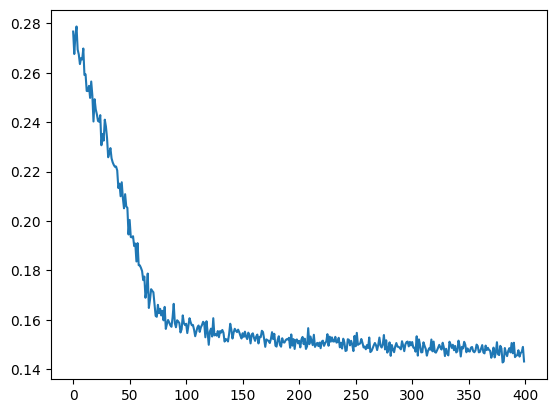

In [14]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [ ]:
# torch.save(up_changer.state_dict(), 'tim_files/up_changer.pth')

In [26]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


In [36]:
torch.save(test_predictions, 'submission_files/tim_deep1_pred.pt')

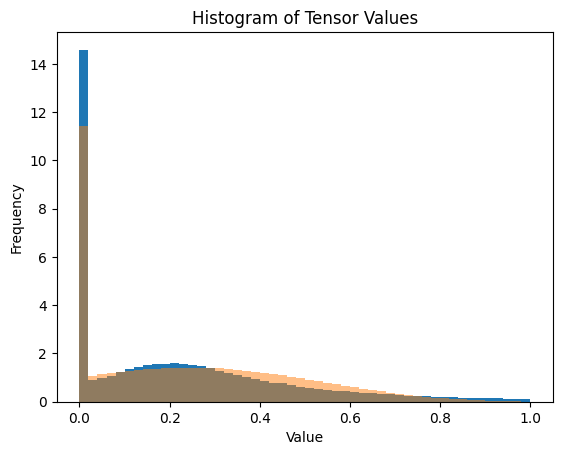

In [34]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

In [35]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep1.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
